1. Cargar y limpiar datos

In [1]:
import pandas as pd
import json
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
file_path = './../data/linkedin_profiles_v9.csv'  # Cambia esto por la ruta correcta de tu archivo
df = pd.read_csv(file_path)

# Filtrar perfiles sin empresa actual
df['employed'] = df['current_company:company_id'].notna().astype(int)

2. Extracción de características

In [2]:
# Función para contar entradas en columnas JSON-like
def count_entries(column):
    try:
        return len(eval(column)) if pd.notnull(column) and column.startswith('[') else 0
    except:
        return 0

# Aplicar funciones de extracción
df['education_count'] = df['education'].apply(count_entries)
df['certifications_count'] = df['certifications'].apply(count_entries)
df['languages_count'] = df['languages'].apply(count_entries)
df['volunteer_experience_count'] = df['volunteer_experience'].apply(count_entries)
df['courses_count'] = df['сourses'].apply(count_entries)

# Función para calcular años de experiencia a partir del campo JSON
def extract_experience_years_from_json(experience):
    total_years = 0
    total_months = 0
    try:
        experience_data = json.loads(experience)
        for job in experience_data:
            positions = job.get('positions', [])
            for position in positions:
                duration_short = position.get('duration_short', '')
                # Extraer años y meses de 'duration_short'
                years_match = re.search(r'(\d+)\s*years?', duration_short)
                months_match = re.search(r'(\d+)\s*months?', duration_short)
                if years_match:
                    total_years += int(years_match.group(1))
                if months_match:
                    total_months += int(months_match.group(1))
        total_years += total_months // 12
        return total_years
    except Exception as e:
        print(f"Error procesando la experiencia: {e}")
        return 0

# Aplicar la función de experiencia
df['experience_years'] = df['experience'].apply(lambda x: extract_experience_years_from_json(x) if isinstance(x, str) else 0)

Error procesando la experiencia: expected string or bytes-like object, got 'NoneType'
Error procesando la experiencia: expected string or bytes-like object, got 'NoneType'
Error procesando la experiencia: expected string or bytes-like object, got 'NoneType'
Error procesando la experiencia: expected string or bytes-like object, got 'NoneType'
Error procesando la experiencia: expected string or bytes-like object, got 'NoneType'


3. Preparación de Datos para Entrenamiento

In [3]:
# Preparar las características y etiquetas
features = ['education_count', 'certifications_count', 'languages_count', 
            'volunteer_experience_count', 'courses_count', 'experience_years']
X = df[features].fillna(0)
y = df['employed']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Entrenamiento y Evaluación de Múltiples Modelos (XGBoost)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Configurar los modelos y parámetros para GridSearch
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ejecutar el Grid Search
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros para XGBoost: {grid_search_xgb.best_params_}")

# Evaluar el modelo optimizado con StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el modelo XGBoost con los mejores hiperparámetros
xgb_model = XGBClassifier(**grid_search_xgb.best_params_, random_state=42)

# Convertir y_train a numpy array para evitar problemas de indexación
y_train_array = np.array(y_train)

# Inicializar listas para almacenar las métricas de cada pliegue
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

# Realizar la validación cruzada estratificada
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Dividir los datos en entrenamiento y validación para cada pliegue
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Aplicar SMOTE en cada fold para balancear las clases
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)

    # Entrenar el modelo en el pliegue actual
    xgb_model.fit(X_fold_resampled, y_fold_resampled)
    y_fold_pred = xgb_model.predict(X_fold_val)

    # Calcular métricas de rendimiento
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])
    confusion_matrices.append(confusion_matrix(y_fold_val, y_fold_pred))

# Mostrar los resultados promediados de todos los pliegues
print(f"Precision promedio: {np.mean(precision_scores):.4f}")
print(f"Recall promedio: {np.mean(recall_scores):.4f}")
print(f"F1-Score promedio: {np.mean(f1_scores):.4f}")

# Mostrar la matriz de confusión promediada
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print("Matriz de Confusión Promediada:")
print(mean_confusion_matrix)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.6}
Precision promedio: 0.6196
Recall promedio: 0.6086
F1-Score promedio: 0.6089
Matriz de Confusión Promediada:
[[37.6 22.8]
 [32.  47.6]]


5. Predicción de Candidatos Potenciales (XGBoost)

In [5]:
# Usar el modelo optimizado para predecir candidatos potenciales sin empleo
unemployed_profiles = df[df['employed'] == 0].copy()
unemployed_features = unemployed_profiles[features].fillna(0)
unemployed_features_scaled = scaler.transform(unemployed_features)

unemployed_profiles['predicted_employed'] = xgb_model.predict(unemployed_features_scaled)

potential_candidates = unemployed_profiles[unemployed_profiles['predicted_employed'] == 1]
potential_candidates.to_csv('./../data/potential_candidates_optimized.csv', index=False)
print("Candidatos potenciales guardados en 'potential_candidates_optimized.csv'")

Candidatos potenciales guardados en 'potential_candidates_optimized.csv'


4.1 Entrenamiento y evaluación de modelos (Random Forest)

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Configurar los parámetros para GridSearch de Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ejecutar el Grid Search
grid_search_rf.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros para Random Forest: {grid_search_rf.best_params_}")

# Crear el modelo de Random Forest con los mejores hiperparámetros
best_params_rf = grid_search_rf.best_params_
rf_model = RandomForestClassifier(**best_params_rf, random_state=42)

# Evaluar el modelo optimizado con StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas de cada pliegue
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []
confusion_matrices_rf = []

# Realizar la validación cruzada estratificada
for train_index, test_index in skf.split(X_train_scaled, y_train_array):
    # Dividir los datos en entrenamiento y validación para cada pliegue
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_val = y_train_array[train_index], y_train_array[test_index]

    # Aplicar SMOTE en cada fold para balancear las clases
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)

    # Entrenar el modelo en el pliegue actual
    rf_model.fit(X_fold_resampled, y_fold_resampled)
    y_fold_pred = rf_model.predict(X_fold_val)

    # Calcular métricas de rendimiento
    report = classification_report(y_fold_val, y_fold_pred, output_dict=True)
    precision_scores_rf.append(report['weighted avg']['precision'])
    recall_scores_rf.append(report['weighted avg']['recall'])
    f1_scores_rf.append(report['weighted avg']['f1-score'])
    confusion_matrices_rf.append(confusion_matrix(y_fold_val, y_fold_pred))

# Mostrar los resultados promediados de todos los pliegues
print(f"Precision promedio (Random Forest): {np.mean(precision_scores_rf):.4f}")
print(f"Recall promedio (Random Forest): {np.mean(recall_scores_rf):.4f}")
print(f"F1-Score promedio (Random Forest): {np.mean(f1_scores_rf):.4f}")

# Mostrar la matriz de confusión promediada
mean_confusion_matrix_rf = np.mean(confusion_matrices_rf, axis=0)
print("Matriz de Confusión Promediada (Random Forest):")
print(mean_confusion_matrix_rf)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\pascu\Desktop\MÁSTER INTELIGENCIA ARTIFICIAL\TFM\Talent-Analyzer-AI\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores parámetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Precision promedio (Random Forest): 0.6424
Recall promedio (Random Forest): 0.6371
F1-Score promedio (Random Forest): 0.6346
Matriz de Confusión Promediada (Random Forest):
[[34.8 25.6]
 [25.2 54.4]]


5. Predicción de Candidatos Potenciales (Random Forest)

In [7]:
# Filtrar perfiles sin empleo
unemployed_profiles_rf = df[df['employed'] == 0].copy()
unemployed_features_rf = unemployed_profiles_rf[features].fillna(0)
unemployed_features_scaled_rf = scaler.transform(unemployed_features_rf)

# Predecir candidatos potenciales con el modelo optimizado de Random Forest
unemployed_profiles_rf['predicted_employed'] = rf_model.predict(unemployed_features_scaled_rf)

# Filtrar perfiles que son candidatos potenciales
potential_candidates_rf = unemployed_profiles_rf[unemployed_profiles_rf['predicted_employed'] == 1]

# Guardar los candidatos potenciales en un archivo CSV
potential_candidates_rf.to_csv('./../data/potential_candidates_random_forest.csv', index=False)
print("Candidatos potenciales guardados en 'potential_candidates_random_forest.csv'")

Candidatos potenciales guardados en 'potential_candidates_random_forest.csv'


Interpretación de Resultados
    Random Forest:

        Tiene una mayor precisión promedio (0.6424) y recall promedio (0.6371) que XGBoost, lo que indica que Random Forest identifica mejor tanto los positivos verdaderos como los negativos verdaderos.
        La F1-Score promedio también es mayor (0.6346) en comparación con XGBoost (0.6089), lo que sugiere que Random Forest tiene un equilibrio más sólido entre precisión y recall.

    XGBoost:

        Aunque XGBoost tiene un rendimiento decente, su precisión, recall y F1-score son ligeramente inferiores a los de Random Forest.
        La matriz de confusión muestra que XGBoost tiene más falsos negativos (32) que Random Forest (25.2), lo que indica que XGBoost es menos efectivo para identificar correctamente los verdaderos positivos.

Optimización y mejora de Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),  # Limitar la profundidad máxima
    'min_samples_split': randint(5, 20),  # Aumentar para regularización
    'min_samples_leaf': randint(2, 10),  # Aumentar para regularización
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Configurar RandomizedSearchCV para Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=100,                   # Número de combinaciones de parámetros a probar
    scoring='f1_weighted',        # Métrica de evaluación
    cv=5,                         # Validación cruzada de 5 pliegues
    verbose=2,                    # Nivel de detalle en la salida
    random_state=42,
    n_jobs=-1                     # Usar todos los núcleos disponibles
)

# Ejecutar Randomized Search
random_search_rf.fit(X_train_resampled, y_train_resampled)
print(f"Mejores parámetros después de Randomized Search: {random_search_rf.best_params_}")

# Crear el modelo de Random Forest con los mejores hiperparámetros encontrados
# Reajustar el modelo usando class_weight='balanced'
# Ajustar el modelo Random Forest con class_weight
optimized_rf_model = RandomForestClassifier(
    **random_search_rf.best_params_,
    class_weight={0: 1.5, 1: 1},  # Dar más peso a la clase 0
    random_state=42
)
optimized_rf_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\pascu\Desktop\MÁSTER INTELIGENCIA ARTIFICIAL\TFM\Talent-Analyzer-AI\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores parámetros después de Randomized Search: {'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 351}


RandomForestClassifier(class_weight={0: 1.5, 1: 1}, max_depth=8,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=11, n_estimators=351, random_state=42)

In [9]:
# Predecir probabilidades en el conjunto de prueba
y_probs = optimized_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva de precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calcular F1-Score de forma más robusta
f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)

# Encontrar el umbral óptimo para maximizar el F1-Score
optimal_threshold = thresholds[f1_scores.argmax()]
print(f"Umbral óptimo basado en el F1-Score: {optimal_threshold}")

# Establecer el umbral final en 0.45 o 0.50
final_threshold = 0.4125
y_pred_final = (y_probs >= final_threshold).astype(int)
print(f"Classification Report con umbral final {final_threshold}:\n", classification_report(y_test, y_pred_final))

Umbral óptimo basado en el F1-Score: 0.272737466161543
Classification Report con umbral final 0.4125:
               precision    recall  f1-score   support

           0       0.61      0.53      0.57       126
           1       0.69      0.75      0.72       174

    accuracy                           0.66       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.66      0.66      0.66       300



C:\Users\pascu\AppData\Local\Temp\ipykernel_26892\1227063827.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = np.where(precision + recall > 0, 2 * (precision * recall) / (precision + recall), 0)


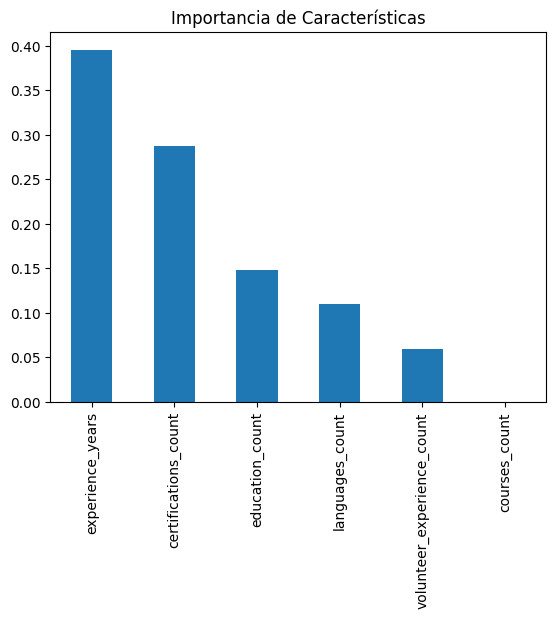

In [10]:
# Entrenar el modelo de Random Forest optimizado para calcular la importancia de las características
optimized_rf_model.fit(X_train_resampled, y_train_resampled)

# Extraer la importancia de las características
feature_importances = pd.Series(optimized_rf_model.feature_importances_, index=features)
feature_importances.sort_values(ascending=False).plot(kind='bar', title='Importancia de Características')
plt.show()

# Seleccionar las características más importantes (por encima de un umbral)
important_features = feature_importances[feature_importances > 0.05].index.tolist()
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Definir un ensemble stacking con tres modelos optimizados
estimators = [
    ('rf', RandomForestClassifier(**random_search_rf.best_params_, random_state=42)),
    ('xgb', XGBClassifier(**grid_search_xgb.best_params_, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))  # Agregar LightGBM al ensemble
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# Entrenar el ensemble
stacking_model.fit(X_train_scaled, y_train)

# Evaluar el ensemble en el conjunto de prueba
y_pred_stacking = stacking_model.predict(X_test_scaled)
print("Classification Report para Ensemble (Stacking) con LightGBM:\n", classification_report(y_test, y_pred_stacking))


[LightGBM] [Info] Number of positive: 398, number of negative: 302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568571 -> initscore=0.276025
[LightGBM] [Info] Start training from score 0.276025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li